Agentic RAG Proof of concept az agentic alapú működés demonstrálására

In [ ]:
%pip install -U \
  transformers \
  langgraph langchain-community langchain-text-splitters langchain-ollama\
  sentence-transformers \
  torch langchain-docling \
  faiss-cpu

Note: you may need to restart the kernel to use updated packages.


In [2]:
import random
import numpy as np
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

In [3]:
from langchain_docling import DoclingLoader
from docling.chunking import HybridChunker
from langchain_docling.loader import ExportType

FILE_PATH = ["https://arxiv.org/pdf/2506.19676"]
EMBED_MODEL_ID = "sentence-transformers/all-MiniLM-L12-v2"
GEN_MODEL_ID = "ollama:qwen3:4b"
EXPORT_TYPE = ExportType.DOC_CHUNKS

loader = DoclingLoader(
    file_path=FILE_PATH,
    export_type=EXPORT_TYPE,
    chunker=HybridChunker(tokenizer=EMBED_MODEL_ID),
)

docs = loader.load()

if EXPORT_TYPE == ExportType.DOC_CHUNKS:
    splits = docs
elif EXPORT_TYPE == ExportType.MARKDOWN:
    from langchain_text_splitters import MarkdownHeaderTextSplitter

    splitter = MarkdownHeaderTextSplitter(
        headers_to_split_on=[
            ("#", "Header_1"),
            ("##", "Header_2"),
            ("###", "Header_3"),
        ],
    )
    splits = [split for doc in docs for split in splitter.split_text(doc.page_content)]
else:
    raise ValueError(f"Unexpected export type: {EXPORT_TYPE}")

for d in splits[:3]:
    print(f"- {d.page_content=}")
print("...")

/Users/zelenyianszkimate/Documents/Agentic-RAG-PoC/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/zelenyianszkimate/Documents/Agentic-RAG-PoC/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/zelenyianszkimate/Documents/Agentic-RAG-PoC/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Token indices sequence length is longer than the specified maximum sequence length for this model (5188 > 512). Running this sequence through the model will result in inde

- d.page_content='A Survey of LLM-Driven AI Agent Communication: Protocols, Security Risks, and Defense Countermeasures\nDezhang Kong, Shi Lin, Zhenhua Xu, Zhebo Wang, Minghao Li, Yufeng Li, Yilun Zhang, Hujin Peng, Zeyang Sha, Yuyuan Li, Changting Lin, Xun Wang, Xuan Liu, Ningyu Zhang, Chaochao Chen, Muhammad Khurram Khan, Meng Han'
- d.page_content='A Survey of LLM-Driven AI Agent Communication: Protocols, Security Risks, and Defense Countermeasures\nAbstract -In recent years, Large-Language-Model-driven AI agents have exhibited unprecedented intelligence and adaptability, and are rapidly changing human production and life. Nowadays, agents are undergoing a new round of evolution. They no longer act as an isolated island like LLMs. Instead, they start to communicate with diverse external entities, such as other agents and tools, to perform more complex tasks collectively. Under this trend, agent communication is regarded as a foundational pillar of the future AI ecosystem, and many o

In [4]:
from langchain_community.docstore.in_memory import InMemoryDocstore
from langchain_community.vectorstores import FAISS
import faiss
from langchain.tools.retriever import create_retriever_tool
from langchain_community.embeddings import HuggingFaceEmbeddings

embeddings = HuggingFaceEmbeddings(model_name=EMBED_MODEL_ID)

print("FAISS index létrehozása a dokumentumokból...")
vectorstore = FAISS.from_documents(splits, embeddings)

print(f"FAISS index méret: {vectorstore.index.ntotal}")
print(f"Dokumentumok száma: {len(splits)}")

retriever = vectorstore.as_retriever()

retriever_tool = create_retriever_tool(
    retriever,
    "arxiv_paper_retriever",
    "Retrieves and answers the question about the arxiv paper",
)

/var/folders/gh/wtmb1km14f710f4f7s07wk380000gn/T/ipykernel_83252/784826542.py:7: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(model_name=EMBED_MODEL_ID)


FAISS index létrehozása a dokumentumokból...
FAISS index méret: 695
Dokumentumok száma: 695


In [5]:
from langgraph.graph import MessagesState
from langchain_ollama import ChatOllama
from langchain.chat_models import init_chat_model

response_model = init_chat_model("ollama:qwen3:4b", temperature=0)


def generate_query_or_respond(state: MessagesState):
    """Call the model to generate a response based on the current state. Given
    the question, it will decide to retrieve using the retriever tool, or simply respond to the user.
    """
    response = (
        response_model
        .bind_tools([retriever_tool]).invoke(state["messages"])
    )
    return {"messages": [response]}

In [6]:
input = {
    "messages": [
        {
            "role": "user",
            "content": "Tell me about the main idea of the paper",
        }
    ]
}
generate_query_or_respond(input)["messages"][-1].pretty_print()

================================== Ai Message ==================================

<think>
Okay, the user wants to know the main idea of a paper. But wait, they didn't specify which paper. Hmm, the function provided is arxiv_paper_retriever, which requires a query. Since the user didn't mention a specific paper title or ID, I can't retrieve the paper without more info. I should ask them to provide the title or arXiv ID so I can look it up. Let me check the tools again. The function needs a "query" parameter. So I need to prompt the user for the paper details. Yeah, I can't proceed without that. Let me respond by requesting the paper title or ID.
</think>

I need more information to help you. Could you please specify which paper you're interested in? For example, provide the paper title, author names, or arXiv ID so I can look it up using the arXiv paper retriever.


In [7]:
from pydantic import BaseModel, Field
from typing import Literal

GRADE_PROMPT = (
    "You are a grader assessing relevance of a retrieved document to a user question. \n "
    "Here is the retrieved document: \n\n {context} \n\n"
    "Here is the user question: {question} \n"
    "If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n"
    "Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."
)


class GradeDocuments(BaseModel):
    """Grade documents using a binary score for relevance check."""

    binary_score: str = Field(
        description="Relevance score: 'yes' if relevant, or 'no' if not relevant"
    )


grader_model = init_chat_model("ollama:qwen3:4b", temperature=0)


def grade_documents(
    state: MessagesState,
) -> Literal["generate_answer", "rewrite_question"]:
    """Determine whether the retrieved documents are relevant to the question."""
    question = state["messages"][0].content
    context = state["messages"][-1].content

    prompt = GRADE_PROMPT.format(question=question, context=context)
    response = (
        grader_model
        .with_structured_output(GradeDocuments).invoke(
            [{"role": "user", "content": prompt}]
        )
    )
    score = response.binary_score

    if score == "yes":
        return "generate_answer"
    else:
        return "rewrite_question"

In [8]:
from langchain_core.messages import convert_to_messages

input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                "content": "What does Lilian Weng say about types of reward hacking?",
            },
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        "id": "1",
                        "name": "retrieve_blog_posts",
                        "args": {"query": "types of reward hacking"},
                    }
                ],
            },
            {"role": "tool", "content": "meow", "tool_call_id": "1"},
        ]
    )
}
grade_documents(input)

'rewrite_question'

In [9]:
input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                "content": "What is the main idea of the paper?",
            },
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        "id": "1",
                        "name": "arxiv_paper_retriever",
                        "args": {"query": "paper main idea"},
                    }
                ],
            },
            {"role": "tool", "content": "The main idea of the paper is that agent communication is a new and promising research field.", "tool_call_id": "1"},
        ]
    )
}
grade_documents(input)

'generate_answer'

In [10]:
from langchain_core.messages import HumanMessage

REWRITE_PROMPT = (
    "Look at the input and try to reason about the underlying semantic intent / meaning.\n"
    "Here is the initial question:"
    "\n ------- \n"
    "{question}"
    "\n ------- \n"
    "Formulate an improved question:"
)


def rewrite_question(state: MessagesState):
    """Rewrite the original user question."""
    messages = state["messages"]
    question = messages[0].content
    prompt = REWRITE_PROMPT.format(question=question)
    response = response_model.invoke([{"role": "user", "content": prompt}])
    return {"messages": [HumanMessage(content=response.content)]}

In [11]:
input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                "content": "What is the main idea of the paper?",
            },
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        "id": "1",
                        "name": "arxiv_paper_retriever",
                        "args": {"query": "paper main idea"},
                    }
                ],
            },
            {"role": "tool", "content": "meow", "tool_call_id": "1"},
        ]
    )
}

response = rewrite_question(input)
print(response["messages"][-1].content)

<think>
Okay, the user wants me to look at an initial question about a paper's main idea and formulate an improved version. Let me unpack this carefully.

First, the original question is quite straightforward: "What is the main idea of the paper?" Hmm... this seems like a standard academic query, probably from someone reading research papers. But I wonder about the context - is this for a student working on literature review? A researcher verifying understanding? The phrasing feels a bit too vague though.

*checks mental notes* Ah! The real issue here is that "main idea" is ambiguous in academic contexts. In papers, we usually mean either: 
- The central thesis/conclusion (what the author argues)
- The core contribution (what's novel)
- The overarching theme (if it's a theoretical paper)
- Or even the key finding (for empirical studies)

The user probably needs precision. I recall that in scholarly communication, we often distinguish between "main contribution" and "central argument". 

In [12]:
GENERATE_PROMPT = (
    "You are an assistant for question-answering tasks. "
    "Use the following pieces of retrieved context to answer the question. "
    "If you don't know the answer, just say that you don't know. "
    "Use three sentences maximum and keep the answer concise.\n"
    "Question: {question} \n"
    "Context: {context}"
)


def generate_answer(state: MessagesState):
    """Generate an answer."""
    question = state["messages"][0].content
    context = state["messages"][-1].content
    prompt = GENERATE_PROMPT.format(question=question, context=context)
    response = response_model.invoke([{"role": "user", "content": prompt}])
    return {"messages": [response]}

In [13]:
input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                "content": "What is the main idea of the paper?",
            },
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        "id": "1",
                        "name": "arxiv_paper_retriever",
                        "args": {"query": "paper main idea"},
                    }
                ],
            },
            {
                "role": "tool",
                "content": "More precisely, we first present a clear definition of agent communication and categorize the entire lifecycle of agent communication into three stages: user-agent interaction, agent-agent communication, and agent-environment communication. Next, for each communication phase, we dissect related protocols and analyze the security risks according to the communication characteristics. Then, we summarize and outlook on the possible defense countermeasures for each risk. In addition, we conduct experiments using MCP and A2A to help readers better understand the novel vulnerabilities brought by agent communication. Finally, we discuss open issues and future directions in this promising research field.",
                "tool_call_id": "1",
            },
        ]
    )
}

response = generate_answer(input)
response["messages"][-1].pretty_print()

================================== Ai Message ==================================

<think>
Okay, the user is asking for the main idea of a paper based on the retrieved context. Let me look at the context provided.

The context describes a paper that defines agent communication, categorizes its lifecycle into three stages: user-agent, agent-agent, and agent-environment communication. Then it analyzes security risks for each phase, discusses defense countermeasures, conducts experiments with MCP and A2A, and talks about future directions. 

Hmm, the main idea seems to be about the structured approach to agent communication security. The paper breaks down the communication lifecycle into stages, identifies risks, and proposes defenses. The experiments and future work are part of the methodology but the core is the framework for security analysis.

I need to keep it concise. The user wants three sentences max. So I'll focus on the key points: defining communication, categorizing lifecycle s

In [14]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

workflow = StateGraph(MessagesState)

# Define the nodes we will cycle between
workflow.add_node(generate_query_or_respond)
workflow.add_node("retrieve", ToolNode([retriever_tool]))
workflow.add_node(rewrite_question)
workflow.add_node(generate_answer)

workflow.add_edge(START, "generate_query_or_respond")

# Decide whether to retrieve
workflow.add_conditional_edges(
    "generate_query_or_respond",
    # Assess LLM decision (call `retriever_tool` tool or respond to the user)
    tools_condition,
    {
        # Translate the condition outputs to nodes in our graph
        "tools": "retrieve",
        END: END,
    },
)

# Edges taken after the `action` node is called.
workflow.add_conditional_edges(
    "retrieve",
    # Assess agent decision
    grade_documents,
)
workflow.add_edge("generate_answer", END)
workflow.add_edge("rewrite_question", "generate_query_or_respond")

# Compile
graph = workflow.compile()

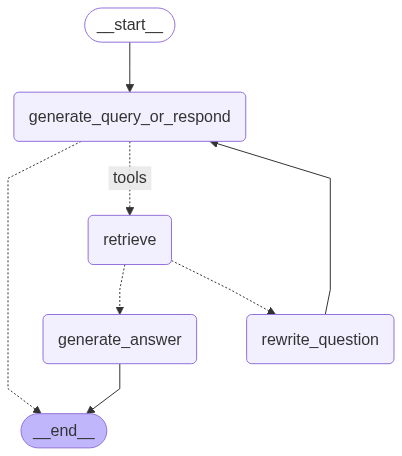

In [15]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
for chunk in graph.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": """What is the main contribution of the AI agent communication paper?""",
            }
        ]
    }
):
    for node, update in chunk.items():
        print("Update from node", node)
        update["messages"][-1].pretty_print()
        print("\n\n")

Update from node generate_query_or_respond
================================== Ai Message ==================================

<think>
Okay, the user is asking about the main contribution of the AI agent communication paper. Hmm, first I need to figure out which specific paper they're referring to. The term "AI agent communication" is pretty broad. There are several papers on this topic, like maybe the one from the AI Safety Institute or something else.

Wait, the tool provided is arxiv_paper_retriever, which takes a query. So I should use that to look up the most relevant paper. The user probably means a recent paper, maybe the one that's popular or has significant contributions. Let me think, there's a paper titled "AI Agent Communication" on arXiv, but I'm not sure. Alternatively, maybe it's a specific paper from a conference.

Since the user didn't specify the title, I need to craft a query that will retrieve the main paper in this area. The query could be "main contribution of AI ag